In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import datetime
import torch
import torch.nn as nn
import numpy as np
import random
import gc
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt


# internal library imports
from dataset import DebrisStatePairsDataset
from model import CNN, UNet
from train import TrainerPairs, CustomDebrisLoss, SparseLoss, AdaptiveSparseLoss
from util.setting_utils import set_seed


In [2]:
# Set the random seed for multiple libraries to ensure repeatability

set_seed(42)

In [3]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data_experiment_prune'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 32
split_proportions = (0.7, 0.15, 0.15)
epochs = 25

timestep_interval = 3
experiment = "base_model_compar_adaploss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet"

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)

In [4]:
# Data set up

# Initialize dataset with scaling
dataset = DebrisStatePairsDataset(root_dir, array_size=256, apply_scaling=True, timestep_interval=timestep_interval)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)



# Dataset stats
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Total dataset size: 3523
Train size: 2549, Validation size: 534, Test size: 440


In [5]:
pair_filenames = dataset.get_pair_filenames()

# Print the filenames for each pair
for i, filenames in enumerate(pair_filenames):
    print(f"Pair {i+1}:")
    print("Current velocity:", filenames['current_velocity'])
    print("Next velocity:", filenames['next_velocity'])
    print("Current thickness:", filenames['current_thickness'])
    print("Next thickness:", filenames['next_thickness'])
    print("Terrain:", filenames['terrain'])
    print()

Pair 1:
Current velocity: 00055_velocity_2.npy
Next velocity: 00055_velocity_5.npy
Current thickness: 00055_thickness_2.npy
Next thickness: 00055_thickness_5.npy
Terrain: 00055_elevation.npy

Pair 2:
Current velocity: 00055_velocity_3.npy
Next velocity: 00055_velocity_6.npy
Current thickness: 00055_thickness_3.npy
Next thickness: 00055_thickness_6.npy
Terrain: 00055_elevation.npy

Pair 3:
Current velocity: 00055_velocity_4.npy
Next velocity: 00055_velocity_7.npy
Current thickness: 00055_thickness_4.npy
Next thickness: 00055_thickness_7.npy
Terrain: 00055_elevation.npy

Pair 4:
Current velocity: 00055_velocity_5.npy
Next velocity: 00055_velocity_8.npy
Current thickness: 00055_thickness_5.npy
Next thickness: 00055_thickness_8.npy
Terrain: 00055_elevation.npy

Pair 5:
Current velocity: 00055_velocity_6.npy
Next velocity: 00055_velocity_9.npy
Current thickness: 00055_thickness_6.npy
Next thickness: 00055_thickness_9.npy
Terrain: 00055_elevation.npy

Pair 6:
Current velocity: 00055_velocity

In [6]:
from matplotlib.colors import LogNorm

def plot_samples(dataset, num_samples=5, use_log_scale=False):
    """
    Plots a specified number of samples from the dataset with separate subplots for 
    each channel, with an option to use a logarithmic color scale.

    Args:
    - dataset (Dataset): The dataset of debris state pairs.
    - num_samples (int): Number of random samples to plot.
    - use_log_scale (bool): Whether to use a logarithmic scale for the color maps.

    """
    if num_samples > len(dataset):
        raise ValueError("num_samples is greater than the total number of samples available in the dataset.")

    # Select random indices
    indices = np.random.choice(len(dataset), size=num_samples, replace=False)
    
    # Create a figure with 2 columns and `num_samples` rows, with 4 subplots per row (2 input, 2 output)
    fig, axs = plt.subplots(nrows=num_samples, ncols=4, figsize=(16, 4 * num_samples))
    
    for i, idx in enumerate(indices):
        # Get the data from the dataset
        input_tensor, output_tensor = dataset[idx]
        
        # Convert tensors to numpy arrays
        input_array = input_tensor.numpy()
        output_array = output_tensor.numpy()
        
        # input includes elevation, current velocity, and thickness
        # and the output includes the next velocity and next thickness
        elevation, current_velocity, current_thickness = input_array
        next_velocity, next_thickness = output_array
        
        # Determine normalization
        norm = LogNorm() if use_log_scale else None

        # Plot each channel
        for j, (data, title) in enumerate([
            (current_velocity, 'Current Velocity'),
            (current_thickness, 'Current Thickness'),
            (next_velocity, 'Next Velocity'),
            (next_thickness, 'Next Thickness')
        ]):
            ax = axs[i, j] if num_samples > 1 else axs[j]
            im = ax.imshow(data, cmap='viridis', norm=norm)
            ax.set_title(f'Sample {idx} - {title}')
            ax.axis('off')
            fig.colorbar(im, ax=ax, orientation='vertical')

    plt.tight_layout()
    plt.show()

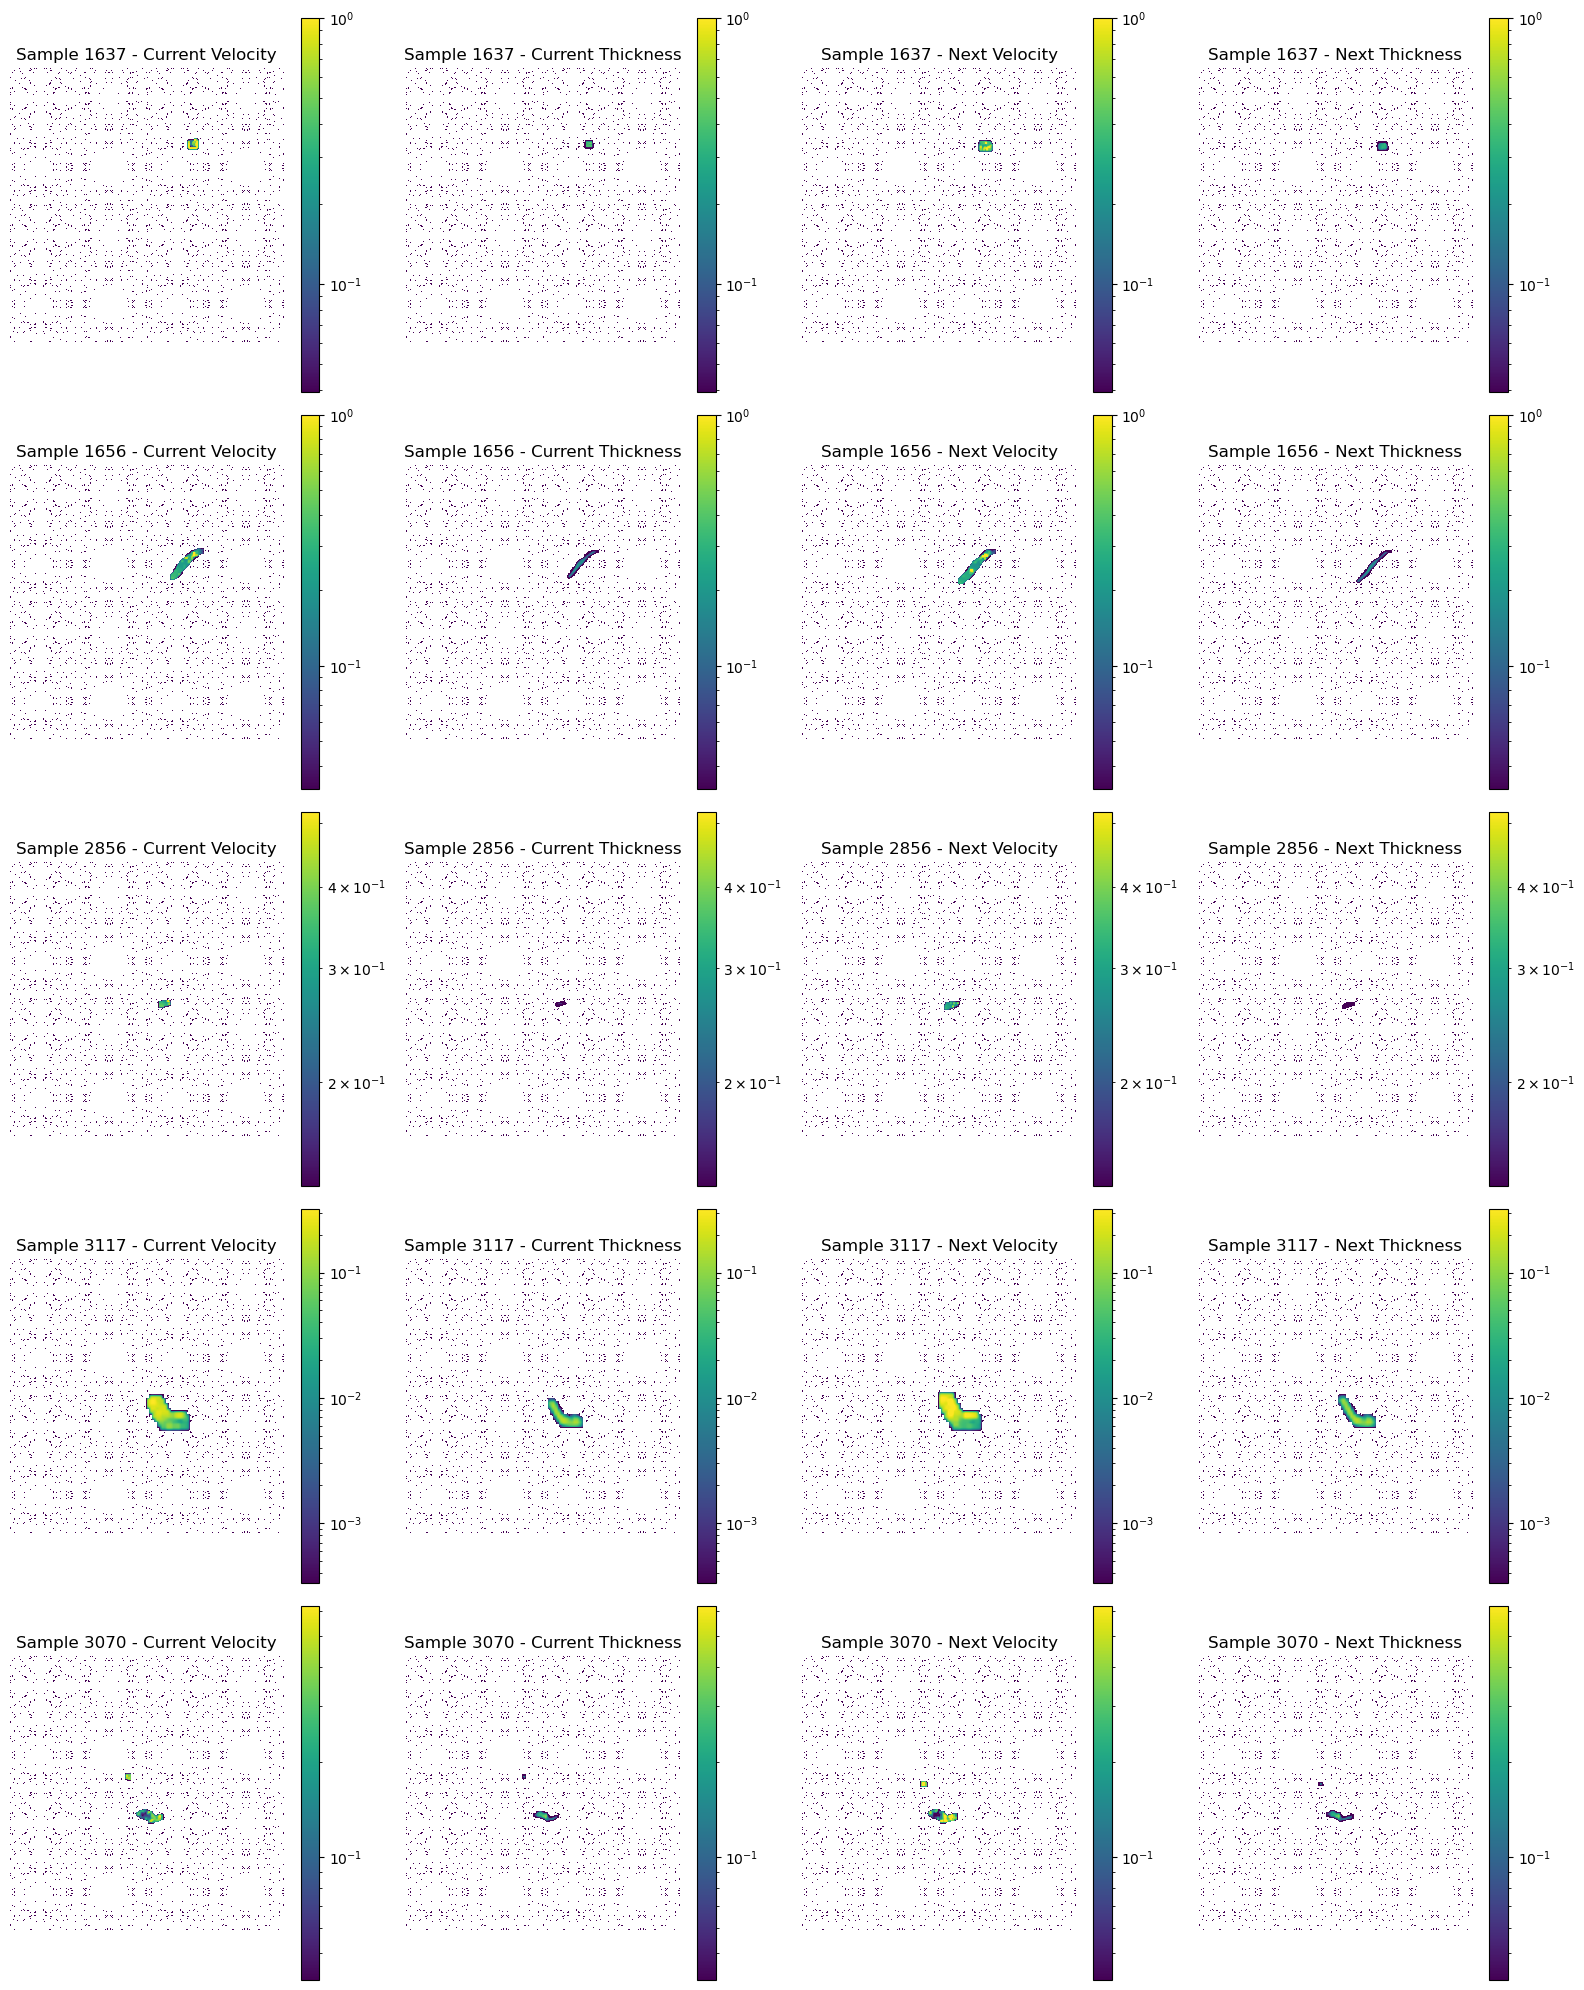

In [7]:
plot_samples(dataset, num_samples=5, use_log_scale=True)

In [8]:
def compute_min_max(dataset):
    min_elevation = np.inf
    max_elevation = -np.inf
    min_velocity = np.inf
    max_velocity = -np.inf
    min_thickness = np.inf
    max_thickness = -np.inf

    for cnn_input, _ in dataset:
        elevation = cnn_input[0, :, :].numpy()
        thickness = cnn_input[1, :, :].numpy()
        velocity = cnn_input[2, :, :].numpy()

        min_elevation = min(min_elevation, elevation.min())
        max_elevation = max(max_elevation, elevation.max())
        min_velocity = min(min_velocity, velocity.min())
        max_velocity = max(max_velocity, velocity.max())
        min_thickness = min(min_thickness, thickness.min())
        max_thickness = max(max_thickness, thickness.max())

    return min_elevation, max_elevation, min_velocity, max_velocity, min_thickness, max_thickness

In [9]:
# Check the range of values in each dataset
train_min_max = compute_min_max(train_loader.dataset)
val_min_max = compute_min_max(val_loader.dataset)
test_min_max = compute_min_max(test_loader.dataset)

print("Train dataset range:")
print("Elevation: [{:.2f}, {:.2f}]".format(*train_min_max[:2]))
print("Velocity: [{:.2f}, {:.2f}]".format(*train_min_max[2:4]))
print("Thickness: [{:.2f}, {:.2f}]".format(*train_min_max[4:]))

print("\nValidation dataset range:")
print("Elevation: [{:.2f}, {:.2f}]".format(*val_min_max[:2]))
print("Velocity: [{:.2f}, {:.2f}]".format(*val_min_max[2:4]))
print("Thickness: [{:.2f}, {:.2f}]".format(*val_min_max[4:]))

print("\nTest dataset range:")
print("Elevation: [{:.2f}, {:.2f}]".format(*test_min_max[:2]))
print("Velocity: [{:.2f}, {:.2f}]".format(*test_min_max[2:4]))
print("Thickness: [{:.2f}, {:.2f}]".format(*test_min_max[4:]))

In [10]:
# Get the current date and time
now = datetime.datetime.now()

# Format date and time in a filename-friendly way
date = now.strftime('%Y-%m-%d_%H-%M')

models = [
    # {'model': CNN(dropout_rate=0.25), 'name': f'{date}_{experiment}_CNN'},
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256], dropout_rate=0.25), 'name': f'{date}_{experiment}_SmallUNet'}, 
    {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512], dropout_rate=0.15), 'name': f'{date}_{experiment}_MedUNet'}
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512, 1024], dropout_rate=0.25), 'name': f'{date}_{experiment}_LargeUNet'}
]

In [11]:
# Create an instance of each architecture
cnn = CNN()
small_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256])
med_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512])
large_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512, 1024])

# Calculate the number of parameters for each architecture
cnn_params = sum(p.numel() for p in cnn.parameters())
small_unet_params = sum(p.numel() for p in small_unet.parameters())
med_unet_params = sum(p.numel() for p in med_unet.parameters())
large_unet_params = sum(p.numel() for p in large_unet.parameters())

# Print the number of parameters for each architecture
print("ComplexCNN parameters:", cnn_params)
print("SimpleUNet parameters:", small_unet_params)
print("LargeUNet parameters:", med_unet_params)
print("UNet parameters:", large_unet_params)

Training on device: cuda.
Using 2 GPUs!
Training 2024-04-27_20-36_base_model_compar_adaploss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet...
Epoch [1/25], Loss: 0.1106
Validation Loss: 0.0977
Current Learning Rate: [1e-05]
Epoch [2/25], Loss: 0.0774
Validation Loss: 0.0922
Current Learning Rate: [1e-05]
Epoch [3/25], Loss: 0.0701
Validation Loss: 0.0787
Current Learning Rate: [1e-05]
Epoch [4/25], Loss: 0.0591
Validation Loss: 0.0682
Current Learning Rate: [1e-05]
Epoch [5/25], Loss: 0.0513
Validation Loss: 0.0605
Current Learning Rate: [1e-05]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-27_20-36_base_model_compar_adaploss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet/model_epoch_5.pth
Epoch [6/25], Loss: 0.0457
Validation Loss: 0.0549
Current Learning Rate: [1e-05]
Epoch [7/25], Loss: 0.0416
Validation Loss: 0.0506
Current Learning Rate: [1e-05]
Epoch [8/25], Loss: 0.0382
Validation Loss: 0.0469
Current Lea

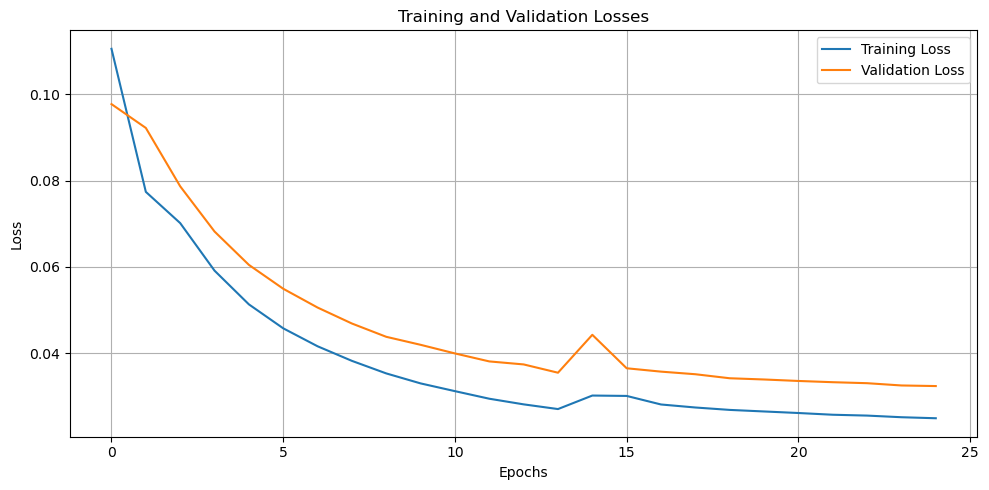

Finished training 2024-04-27_20-36_base_model_compar_adaploss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet.
GPU memory cleared after training 2024-04-27_20-36_base_model_compar_adaploss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet.


In [12]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

# Train each model
for model_info in models:
    
    model = model_info['model']

    # Check if multiple GPUs are available and wrap the model using nn.DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        # This will wrap the model for use with multiple GPUs
        model = torch.nn.DataParallel(model)
    
    # Move model to the appropriate device
    model.to(device)
    
    # Define the loss function and optimizer
    # criterion = nn.MSELoss(reduction='sum')
    # criterion = nn.L1Loss(reduction='sum')
    # criterion = nn.SmoothL1Loss(reduction='sum')
    # criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
    criterion = AdaptiveSparseLoss()
    optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    
    # Initialize the trainer
    model_name = model_info['name']
    trainer = TrainerPairs(model, optimizer, criterion, device, model_name=model_name, checkpoint_dir=checkpoint_dir, patience=10)
    
    # Train the model
    print(f"Training {model_name}...")
    trainer.train(train_loader, val_loader, epochs=epochs)
    
    print(f"Finished training {model_name}.")

    # Clean-up
    del model
    del optimizer
    del trainer
    torch.cuda.empty_cache()  # Clear memory cache
    gc.collect()  # Collect garbage
    
    print(f"GPU memory cleared after training {model_name}.")

In [13]:
experiment = "base_model_compar_mse-mean_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet"

# Get the current date and time
now = datetime.datetime.now()

# Format date and time in a filename-friendly way
date = now.strftime('%Y-%m-%d_%H-%M')

models = [
    # {'model': CNN(dropout_rate=0.25), 'name': f'{date}_{experiment}_CNN'},
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256], dropout_rate=0.25), 'name': f'{date}_{experiment}_SmallUNet'}, 
    {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512], dropout_rate=0.15), 'name': f'{date}_{experiment}_MedUNet'}
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512, 1024], dropout_rate=0.25), 'name': f'{date}_{experiment}_LargeUNet'}
]

Training on device: cuda.
Using 2 GPUs!
Training 2024-04-27_21-01_base_model_compar_mse-mean_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet...
Epoch [1/25], Loss: 0.0470
Validation Loss: 0.0114
Current Learning Rate: [1e-05]
Epoch [2/25], Loss: 0.0010
Validation Loss: 0.0004
Current Learning Rate: [1e-05]
Epoch [3/25], Loss: 0.0003
Validation Loss: 0.0004
Current Learning Rate: [1e-05]
Epoch [4/25], Loss: 0.0003
Validation Loss: 0.0003
Current Learning Rate: [1e-05]
Epoch [5/25], Loss: 0.0003
Validation Loss: 0.0003
Current Learning Rate: [1e-05]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-27_21-01_base_model_compar_mse-mean_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet/model_epoch_5.pth
Epoch [6/25], Loss: 0.0003
Validation Loss: 0.0003
Current Learning Rate: [1e-05]
Epoch [7/25], Loss: 0.0003
Validation Loss: 0.0003
Current Learning Rate: [1e-05]
Epoch [8/25], Loss: 0.0003
Validation Loss: 0.0003
Current Lea

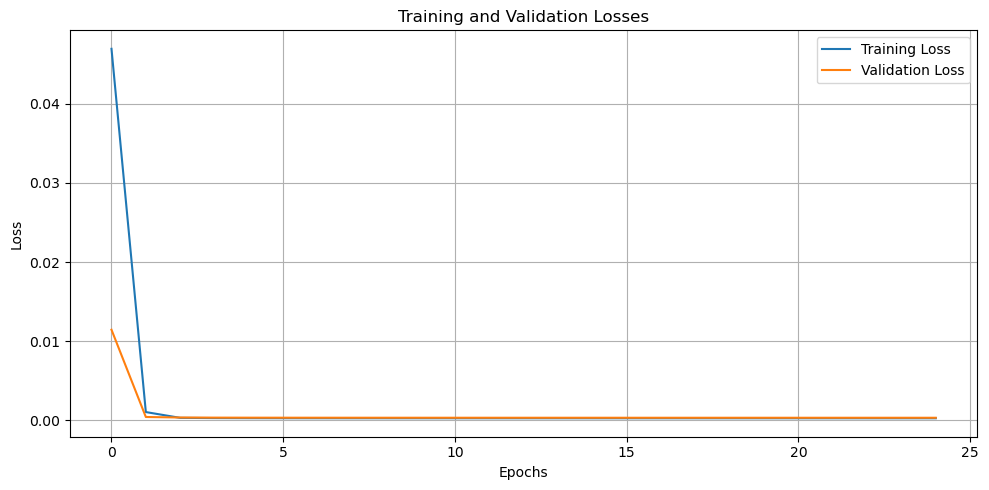

Finished training 2024-04-27_21-01_base_model_compar_mse-mean_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet.
GPU memory cleared after training 2024-04-27_21-01_base_model_compar_mse-mean_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet.


In [14]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

# Train each model
for model_info in models:
    
    model = model_info['model']

    # Check if multiple GPUs are available and wrap the model using nn.DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        # This will wrap the model for use with multiple GPUs
        model = torch.nn.DataParallel(model)
    
    # Move model to the appropriate device
    model.to(device)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss(reduction='mean')
    # criterion = nn.L1Loss(reduction='sum')
    # criterion = nn.SmoothL1Loss(reduction='sum')
    # criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
    # criterion = AdaptiveSparseLoss()
    optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    
    # Initialize the trainer
    model_name = model_info['name']
    trainer = TrainerPairs(model, optimizer, criterion, device, model_name=model_name, checkpoint_dir=checkpoint_dir, patience=10)
    
    # Train the model
    print(f"Training {model_name}...")
    trainer.train(train_loader, val_loader, epochs=epochs)
    
    print(f"Finished training {model_name}.")

    # Clean-up
    del model
    del optimizer
    del trainer
    torch.cuda.empty_cache()  # Clear memory cache
    gc.collect()  # Collect garbage
    
    print(f"GPU memory cleared after training {model_name}.")

In [15]:
experiment = "base_model_compar_mse-sum_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet"

# Get the current date and time
now = datetime.datetime.now()

# Format date and time in a filename-friendly way
date = now.strftime('%Y-%m-%d_%H-%M')

models = [
    # {'model': CNN(dropout_rate=0.25), 'name': f'{date}_{experiment}_CNN'},
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256], dropout_rate=0.25), 'name': f'{date}_{experiment}_SmallUNet'}, 
    {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512], dropout_rate=0.15), 'name': f'{date}_{experiment}_MedUNet'}
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512, 1024], dropout_rate=0.25), 'name': f'{date}_{experiment}_LargeUNet'}
]

Training on device: cuda.
Using 2 GPUs!
Training 2024-04-27_21-24_base_model_compar_mse-sum_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet...
Epoch [1/25], Loss: 45579.7309
Validation Loss: 12051.2300
Current Learning Rate: [1e-05]
Epoch [2/25], Loss: 1807.6491
Validation Loss: 1404.5382
Current Learning Rate: [1e-05]
Epoch [3/25], Loss: 1125.2529
Validation Loss: 1364.4139
Current Learning Rate: [1e-05]
Epoch [4/25], Loss: 1102.3719
Validation Loss: 1349.8582
Current Learning Rate: [1e-05]
Epoch [5/25], Loss: 1092.7936
Validation Loss: 1342.6200
Current Learning Rate: [1e-05]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-27_21-24_base_model_compar_mse-sum_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet/model_epoch_5.pth
Epoch [6/25], Loss: 1087.7121
Validation Loss: 1338.4732
Current Learning Rate: [1e-05]
Epoch [7/25], Loss: 1084.6716
Validation Loss: 1335.9151
Current Learning Rate: [1e-05]
Epoch [8/25], Loss: 

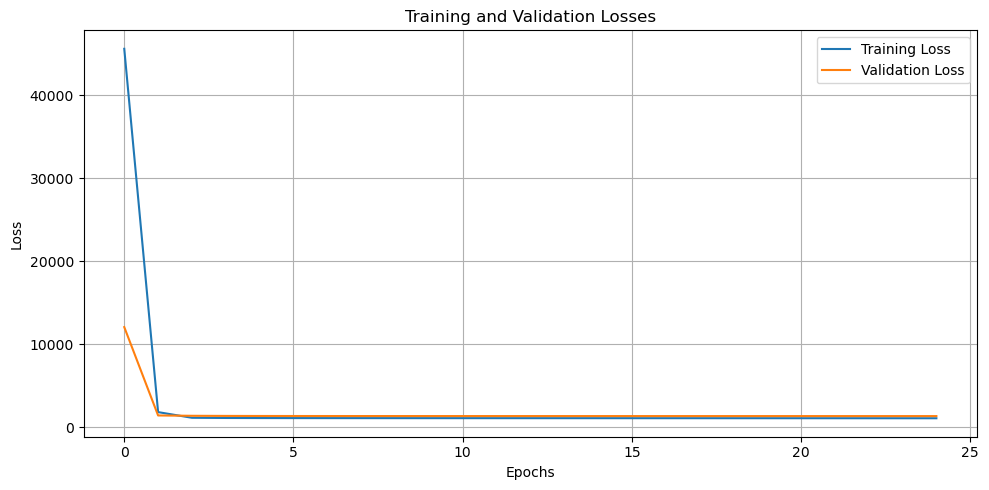

Finished training 2024-04-27_21-24_base_model_compar_mse-sum_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet.
GPU memory cleared after training 2024-04-27_21-24_base_model_compar_mse-sum_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet.


In [16]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

# Train each model
for model_info in models:
    
    model = model_info['model']

    # Check if multiple GPUs are available and wrap the model using nn.DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        # This will wrap the model for use with multiple GPUs
        model = torch.nn.DataParallel(model)
    
    # Move model to the appropriate device
    model.to(device)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss(reduction='sum')
    # criterion = nn.L1Loss(reduction='sum')
    # criterion = nn.SmoothL1Loss(reduction='sum')
    # criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
    # criterion = AdaptiveSparseLoss()
    optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    
    # Initialize the trainer
    model_name = model_info['name']
    trainer = TrainerPairs(model, optimizer, criterion, device, model_name=model_name, checkpoint_dir=checkpoint_dir, patience=10)
    
    # Train the model
    print(f"Training {model_name}...")
    trainer.train(train_loader, val_loader, epochs=epochs)
    
    print(f"Finished training {model_name}.")

    # Clean-up
    del model
    del optimizer
    del trainer
    torch.cuda.empty_cache()  # Clear memory cache
    gc.collect()  # Collect garbage
    
    print(f"GPU memory cleared after training {model_name}.")

In [17]:
experiment = "base_model_compar_l1-sum_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet"

# Get the current date and time
now = datetime.datetime.now()

# Format date and time in a filename-friendly way
date = now.strftime('%Y-%m-%d_%H-%M')

models = [
    # {'model': CNN(dropout_rate=0.25), 'name': f'{date}_{experiment}_CNN'},
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256], dropout_rate=0.25), 'name': f'{date}_{experiment}_SmallUNet'}, 
    {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512], dropout_rate=0.15), 'name': f'{date}_{experiment}_MedUNet'}
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512, 1024], dropout_rate=0.25), 'name': f'{date}_{experiment}_LargeUNet'}
]

Training on device: cuda.
Using 2 GPUs!
Training 2024-04-27_21-47_base_model_compar_l1-sum_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet...
Epoch [1/25], Loss: 497497.5670
Validation Loss: 100322.1976
Current Learning Rate: [1e-05]
Epoch [2/25], Loss: 14359.0754
Validation Loss: 3365.7041
Current Learning Rate: [1e-05]
Epoch [3/25], Loss: 2828.7601
Validation Loss: 3171.7081
Current Learning Rate: [1e-05]
Epoch [4/25], Loss: 2762.8397
Validation Loss: 3161.9143
Current Learning Rate: [1e-05]
Epoch [5/25], Loss: 2753.0714
Validation Loss: 3158.0746
Current Learning Rate: [1e-05]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-27_21-47_base_model_compar_l1-sum_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet/model_epoch_5.pth
Epoch [6/25], Loss: 2749.3165
Validation Loss: 3155.7794
Current Learning Rate: [1e-05]
Epoch [7/25], Loss: 2746.6005
Validation Loss: 3154.2546
Current Learning Rate: [1e-05]
Epoch [8/25], Loss:

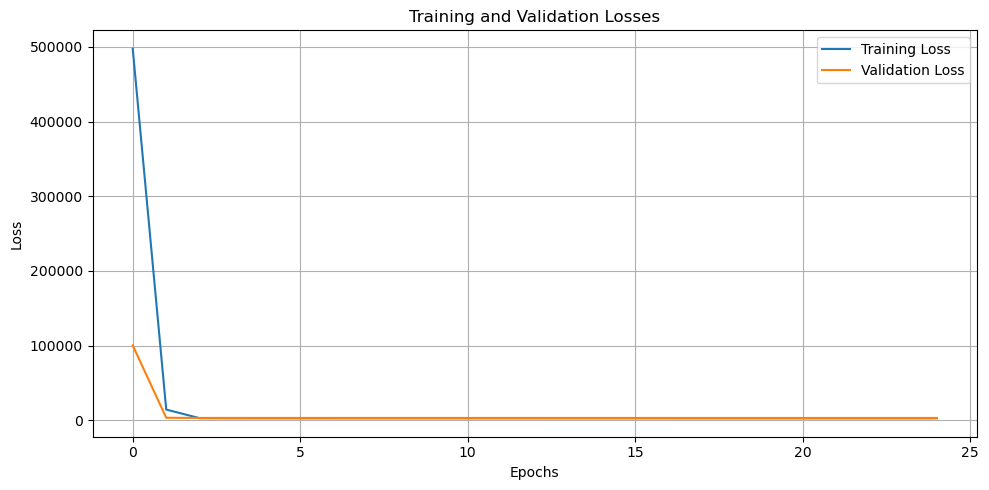

Finished training 2024-04-27_21-47_base_model_compar_l1-sum_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet.
GPU memory cleared after training 2024-04-27_21-47_base_model_compar_l1-sum_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet.


In [18]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

# Train each model
for model_info in models:
    
    model = model_info['model']

    # Check if multiple GPUs are available and wrap the model using nn.DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        # This will wrap the model for use with multiple GPUs
        model = torch.nn.DataParallel(model)
    
    # Move model to the appropriate device
    model.to(device)
    
    # Define the loss function and optimizer
    # criterion = nn.MSELoss(reduction='mean')
    criterion = nn.L1Loss(reduction='sum')
    # criterion = nn.SmoothL1Loss(reduction='sum')
    # criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
    # criterion = AdaptiveSparseLoss()
    optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    
    # Initialize the trainer
    model_name = model_info['name']
    trainer = TrainerPairs(model, optimizer, criterion, device, model_name=model_name, checkpoint_dir=checkpoint_dir, patience=10)
    
    # Train the model
    print(f"Training {model_name}...")
    trainer.train(train_loader, val_loader, epochs=epochs)
    
    print(f"Finished training {model_name}.")

    # Clean-up
    del model
    del optimizer
    del trainer
    torch.cuda.empty_cache()  # Clear memory cache
    gc.collect()  # Collect garbage
    
    print(f"GPU memory cleared after training {model_name}.")

In [19]:
experiment = "base_model_compar_l1-mean_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet"

# Get the current date and time
now = datetime.datetime.now()

# Format date and time in a filename-friendly way
date = now.strftime('%Y-%m-%d_%H-%M')

models = [
    # {'model': CNN(dropout_rate=0.25), 'name': f'{date}_{experiment}_CNN'},
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256], dropout_rate=0.25), 'name': f'{date}_{experiment}_SmallUNet'}, 
    {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512], dropout_rate=0.15), 'name': f'{date}_{experiment}_MedUNet'}
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels, features=[64, 128, 256, 512, 1024], dropout_rate=0.25), 'name': f'{date}_{experiment}_LargeUNet'}
]

Training on device: cuda.
Using 2 GPUs!
Training 2024-04-27_22-11_base_model_compar_l1-mean_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet...
Epoch [1/25], Loss: 0.0792
Validation Loss: 0.0223
Current Learning Rate: [1e-05]
Epoch [2/25], Loss: 0.0025
Validation Loss: 0.0010
Current Learning Rate: [1e-05]
Epoch [3/25], Loss: 0.0007
Validation Loss: 0.0008
Current Learning Rate: [1e-05]
Epoch [4/25], Loss: 0.0007
Validation Loss: 0.0008
Current Learning Rate: [1e-05]
Epoch [5/25], Loss: 0.0007
Validation Loss: 0.0008
Current Learning Rate: [1e-05]
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-27_22-11_base_model_compar_l1-mean_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet/model_epoch_5.pth
Epoch [6/25], Loss: 0.0007
Validation Loss: 0.0008
Current Learning Rate: [1e-05]
Epoch [7/25], Loss: 0.0007
Validation Loss: 0.0008
Current Learning Rate: [1e-05]
Epoch [8/25], Loss: 0.0007
Validation Loss: 0.0008
Current Learn

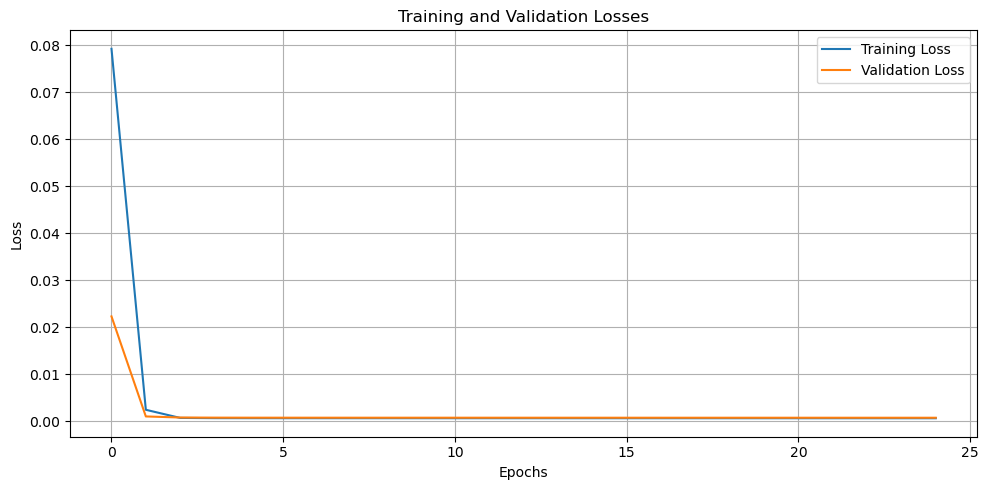

Finished training 2024-04-27_22-11_base_model_compar_l1-mean_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet.
GPU memory cleared after training 2024-04-27_22-11_base_model_compar_l1-mean_batch32_timestep3_lr1e-5_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet.


In [20]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

# Train each model
for model_info in models:
    
    model = model_info['model']

    # Check if multiple GPUs are available and wrap the model using nn.DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        # This will wrap the model for use with multiple GPUs
        model = torch.nn.DataParallel(model)
    
    # Move model to the appropriate device
    model.to(device)
    
    # Define the loss function and optimizer
    # criterion = nn.MSELoss(reduction='mean')
    criterion = nn.L1Loss(reduction='mean')
    # criterion = nn.SmoothL1Loss(reduction='sum')
    # criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
    # criterion = AdaptiveSparseLoss()
    optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    
    # Initialize the trainer
    model_name = model_info['name']
    trainer = TrainerPairs(model, optimizer, criterion, device, model_name=model_name, checkpoint_dir=checkpoint_dir, patience=10)
    
    # Train the model
    print(f"Training {model_name}...")
    trainer.train(train_loader, val_loader, epochs=epochs)
    
    print(f"Finished training {model_name}.")

    # Clean-up
    del model
    del optimizer
    del trainer
    torch.cuda.empty_cache()  # Clear memory cache
    gc.collect()  # Collect garbage
    
    print(f"GPU memory cleared after training {model_name}.")

In [21]:
# # Evaluate the model on the test set
# print("Plotting losses...")
# trainer.plot_losses()

In [22]:
# # Evaluate the model on the test set
# print("Evaluating the model on the test set...")
# trainer.test(test_loader)


In [23]:
# trainer.plot_predictions(test_loader, num_predictions=15)